In [2]:
from tqdm import tqdm, tqdm_notebook
from mxnet import np, npx
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import mxnet.gluon.probability as mgp
from mxnet.gluon.probability import StochasticBlock, StochasticSequential
import matplotlib
import matplotlib.pyplot as plt
from scipy import ndimage, misc

npx.set_np()
data_ctx = mx.cpu()
model_ctx = mx.gpu(0)

In [3]:
def toy_logistic_data(num_examples, input_size=2, weights_prior_stddev=5.0):
    """Generates synthetic data for binary classification.
    Args:
    num_examples: The number of samples to generate (scalar Python `int`).
    input_size: The input space dimension (scalar Python `int`).
    weights_prior_stddev: The prior standard deviation of the weight
        vector. (scalar Python `float`).
    Returns:
    random_weights: Sampled weights as a Numpy `array` of shape
        `[input_size]`.
    random_bias: Sampled bias as a scalar Python `float`.
    design_matrix: Points sampled uniformly from the cube `[-1,
        1]^{input_size}`, as a Numpy `array` of shape `(num_examples,
        input_size)`.
    labels: Labels sampled from the logistic model `p(label=1) =
        logistic(dot(features, random_weights) + random_bias)`, as a Numpy
        `int32` `array` of shape `(num_examples, 1)`.
    """
    random_weights = weights_prior_stddev * np.random.randn(input_size)
    random_bias = np.random.randn()
    design_matrix = np.random.rand(num_examples, input_size) * 2 - 1
    logits = np.reshape(
      np.dot(design_matrix, random_weights) + random_bias,
      (-1, 1))
    p_labels = 1. / (1 + np.exp(-logits))
    labels = np.int32(p_labels > np.random.rand(num_examples, 1))
    return random_weights, random_bias, np.float32(design_matrix), labels


def load_data(batch_size):
    """
    Load MNIST
    """
    mnist_train = gluon.data.vision.MNIST(train=True)
    mnist_test = gluon.data.vision.MNIST(train=False)
    num_worker = 4
    transformer = gluon.data.vision.transforms.ToTensor()
    return (gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                batch_size, shuffle=True,
                                num_workers=num_worker),
          gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                batch_size, shuffle=False,
                                num_workers=num_worker))

Construct A Bayesian dense layer using local reparameterization trick

In [4]:
class LocalReparamDense(StochasticBlock):
    def __init__(self, in_features, out_features, activation=None, flatten=True, dtype='float32'):
        super(LocalReparamDense, self).__init__()
        self._flatten = flatten
        self.qw_x = None
        with self.name_scope():
            self._in_features = in_features
            self._out_features = out_features
            # Parameter of weight
            self.loc_w = self.params.get('loc_w', shape=(out_features, in_features),
                                        dtype=dtype)
            self.scale_w = self.params.get('scale_w', shape=(out_features, in_features),
                                        dtype=dtype)
            # Parameter of bias
            self.bias = self.params.get('bias', shape=(out_features,),
                                        dtype=dtype)
            if activation is not None:
                self.act = gluon.nn.Activation(activation, prefix=activation + '_')
            else:
                self.act = None

    @StochasticBlock.collectLoss
    def hybrid_forward(self, F, x, loc_w, scale_w, bias):
        # We use `fc` operator for matrix multiplication.
        fc = F.npx.fully_connected
        # Directly acquire parameter for A = dot(x, W)
        # with local reparameterization trick:
        qa_loc = fc(x, loc_w, bias=None, no_bias=True, num_hidden=self._out_features,
                    flatten=self._flatten)
        qa_scale = F.np.sqrt(fc(x ** 2, scale_w ** 2, bias=None, no_bias=True,
                      num_hidden=self._out_features, flatten=self._flatten))
        self.qw_x = mgp.Normal(
            loc=qa_loc,
            scale=qa_scale
        )
        # KL(qw_x || px), where px ~ N(0, 1)
        kl = mgp.kl_divergence(self.qw_x, mgp.Normal(0, 1)).sum(-1)
        self.add_loss(kl)
        # Sampling from the network
        fc_samples = self.qw_x.sample() + bias
        if self.act is not None:
            out = self.act(fc_samples)
        else:
            out = fc_samples
        return out

## MNIST classfication with BNN

In [5]:
def train(net, n_epoch, train_iter, test_iter, baseline=False):
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                      {'learning_rate': .001})
    training_loss = []
    validation_loss = []
    loss_func = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=(not baseline))
    metric = mx.metric.Accuracy()
    for epoch in tqdm_notebook(range(n_epoch), desc='epochs'):
        epoch_loss = 0
        metric.reset()
        for batch in train_iter:
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            label = batch[1].as_in_context(model_ctx)
            kl_loss = 0
            with autograd.record():
                logits = net(data)
                classification_loss = loss_func(logits, label)
                # `baseline` model stands for deterministic MLP
                if baseline:
                    loss = classification_loss
                else:
                    for layer_kl_loss in net.losses:
                        kl_loss = kl_loss + layer_kl_loss[0]
                    loss = classification_loss + kl_loss / 256
            loss.backward()
            trainer.step(data.shape[0])
            epoch_loss += np.mean(loss)
        test_loss = 0
        for batch in test_iter:
            data = batch[0].as_in_context(model_ctx).reshape(-1, 28 * 28)
            label = batch[1].as_in_context(model_ctx)
            logits = net(data)
            classification_loss = loss_func(logits, label)
            test_loss += np.mean(classification_loss)
            metric.update([label], [logits.as_nd_ndarray()])
        name, acc = metric.get()
        print('[Epoch %d] Training: %s=%f'%(epoch, name, acc))

        

In [5]:
mlp = nn.HybridSequential()
mlp.add(nn.Dense(256, activation='relu'))
mlp.add(nn.Dense(256, activation='relu'))
mlp.add(nn.Dense(10))
mlp.collect_params().initialize(ctx=model_ctx)
mlp.hybridize()

In [8]:
bnn = StochasticSequential()
bnn.add(LocalReparamDense(784, 256, activation='relu'))
bnn.add(LocalReparamDense(256, 256, activation='relu'))
bnn.add(LocalReparamDense(256, 10))
bnn.collect_params().initialize(ctx=model_ctx)
bnn.hybridize()

In [7]:
%%time
batch_size = 256
train_set, test_set = load_data(batch_size)
train(mlp, 50, train_set, test_set, baseline=True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[Epoch 0] Training: accuracy=0.947200
[Epoch 1] Training: accuracy=0.965500
[Epoch 2] Training: accuracy=0.971700
[Epoch 3] Training: accuracy=0.974100
[Epoch 4] Training: accuracy=0.977400
[Epoch 5] Training: accuracy=0.977900
[Epoch 6] Training: accuracy=0.979500
[Epoch 7] Training: accuracy=0.979000
[Epoch 8] Training: accuracy=0.978500
[Epoch 9] Training: accuracy=0.980100
[Epoch 10] Training: accuracy=0.980200
[Epoch 11] Training: accuracy=0.980700
[Epoch 12] Training: accuracy=0.980900
[Epoch 13] Training: accuracy=0.979300
[Epoch 14] Training: accuracy=0.979400
[Epoch 15] Training: accuracy=0.980200
[Epoch 16] Training: accuracy=0.980300
[Epoch 17] Training: accuracy=0.979500
[Epoch 18] Training: accuracy=0.978100
[Epoch 19] Training: accuracy=0.979300
[Epoch 20] Training: accuracy=0.980500
[Epoch 21] Training: accuracy=0.980300
[Epoch 22] Training: accuracy=0.982500
[Epoch 23] Training: accuracy=0.981400
[Epoch 24] Training: accuracy=0.979900
[Epoch 25] Training: accuracy=0.975

In [9]:
%%time
batch_size = 256
train_set, test_set = load_data(batch_size)
train(bnn, 50, train_set, test_set)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[Epoch 0] Training: accuracy=0.913800
[Epoch 1] Training: accuracy=0.949400
[Epoch 2] Training: accuracy=0.961700
[Epoch 3] Training: accuracy=0.968000
[Epoch 4] Training: accuracy=0.972100
[Epoch 5] Training: accuracy=0.971600
[Epoch 6] Training: accuracy=0.975100
[Epoch 7] Training: accuracy=0.976400
[Epoch 8] Training: accuracy=0.975400
[Epoch 9] Training: accuracy=0.977600
[Epoch 10] Training: accuracy=0.978100
[Epoch 11] Training: accuracy=0.977800
[Epoch 12] Training: accuracy=0.977900
[Epoch 13] Training: accuracy=0.979400
[Epoch 14] Training: accuracy=0.978900
[Epoch 15] Training: accuracy=0.978600
[Epoch 16] Training: accuracy=0.980200
[Epoch 17] Training: accuracy=0.979800
[Epoch 18] Training: accuracy=0.979700
[Epoch 19] Training: accuracy=0.980700
[Epoch 20] Training: accuracy=0.980100
[Epoch 21] Training: accuracy=0.979600
[Epoch 22] Training: accuracy=0.980500
[Epoch 23] Training: accuracy=0.979000
[Epoch 24] Training: accuracy=0.979500
[Epoch 25] Training: accuracy=0.980

In [10]:
%%time
batch_size = 256
train_set, test_set = load_data(batch_size)
train(bnn, 50, train_set, test_set)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[Epoch 0] Training: accuracy=0.915500
[Epoch 1] Training: accuracy=0.947000
[Epoch 2] Training: accuracy=0.959000
[Epoch 3] Training: accuracy=0.966700
[Epoch 4] Training: accuracy=0.970200
[Epoch 5] Training: accuracy=0.973900
[Epoch 6] Training: accuracy=0.973800
[Epoch 7] Training: accuracy=0.975300
[Epoch 8] Training: accuracy=0.976300
[Epoch 9] Training: accuracy=0.976700
[Epoch 10] Training: accuracy=0.977900
[Epoch 11] Training: accuracy=0.978600
[Epoch 12] Training: accuracy=0.979500
[Epoch 13] Training: accuracy=0.978800
[Epoch 14] Training: accuracy=0.978500
[Epoch 15] Training: accuracy=0.980900
[Epoch 16] Training: accuracy=0.980700
[Epoch 17] Training: accuracy=0.979300
[Epoch 18] Training: accuracy=0.980800
[Epoch 19] Training: accuracy=0.980600
[Epoch 20] Training: accuracy=0.980600
[Epoch 21] Training: accuracy=0.978800
[Epoch 22] Training: accuracy=0.980200
[Epoch 23] Training: accuracy=0.981700
[Epoch 24] Training: accuracy=0.979600
[Epoch 25] Training: accuracy=0.979

Next, we perform classfication on white noise to demonstrate the advantages of a Bayesian neural network.

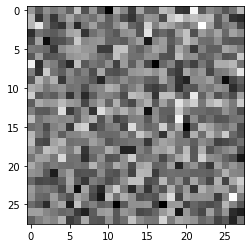

In [116]:
# Generate random noise
x = np.random.randn(28, 28)
plt.imshow(x.asnumpy(), cmap='gray')

In [117]:
num_samples = 100
bnn_prediction = npx.softmax(bnn(np.repeat(np.expand_dims(x, 0), 100, 0).as_in_context(model_ctx))).mean(0).asnumpy()
mlp_prediction = npx.softmax(mlp(np.repeat(np.expand_dims(x, 0), 100, 0).as_in_context(model_ctx))).mean(0).asnumpy()

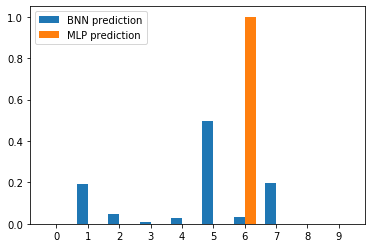

In [120]:
labels = [str(i) for i in range(10)]
x = np.arange(len(labels)).asnumpy()  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, bnn_prediction, width, label='BNN prediction')
rects2 = ax.bar(x + width/2, mlp_prediction, width, label='MLP prediction')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()